# SARCASM DETECTION USING BERT-STYLE MODELS
---------------------------------------
Author:Lokesh
Date: December 2025
Assignment: LLM Fine-tuning Models
-----------------------------------------

This notebook implements sarcasm detection using fine-tuned BERT models and compares performance against traditional baseline models.

# SECTION 1: ENVIRONMENT SETUP AND LIBRARY IMPORTS

In [3]:
# Install required packages
!pip install transformers datasets torch scikit-learn matplotlib seaborn wordcloud -q

# Standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Text processing
import re
from wordcloud import WordCloud
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             classification_report, confusion_matrix, roc_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer

# Deep Learning and Transformers
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (BertTokenizer, BertForSequenceClassification,
                         RobertaTokenizer, RobertaForSequenceClassification,
                         get_linear_schedule_with_warmup)
from torch.optim import AdamW # Corrected import for AdamW
from datasets import load_dataset

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# SECTION 2: DATA LOADING AND INITIAL EXPLORATION

We load the sarcasm dataset from Hugging Face. This dataset contains:
- Text comments from various sources (primarily Reddit)
- Binary labels: 1 for sarcastic, 0 for non-sarcastic
- Additional metadata like author, subreddit, etc.

In [7]:
dataset = load_dataset("raquiba/Sarcasm_News_Headline", split="train")

# Convert to pandas DataFrame for easier manipulation
df = pd.DataFrame(dataset)

print(f"\n Dataset loaded successfully!")
print(f" Total samples: {len(df)}")
print(f"\n Dataset columns: {df.columns.tolist()}")
print(f"\n First few rows:")
print(df.head())

# Basic dataset information
print(f"\n Dataset Info:")
print(df.info())

# Check for missing values
print(f"\n Missing values:")
print(df.isnull().sum())

README.md: 0.00B [00:00, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


train.json: 0.00B [00:00, ?B/s]

test.json: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/28619 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/26709 [00:00<?, ? examples/s]


 Dataset loaded successfully!
 Total samples: 28619

 Dataset columns: ['is_sarcastic', 'headline', 'article_link']

 First few rows:
   is_sarcastic                                           headline  \
0             1  thirtysomething scientists unveil doomsday clo...   
1             0  dem rep. totally nails why congress is falling...   
2             0  eat your veggies: 9 deliciously different recipes   
3             1  inclement weather prevents liar from getting t...   
4             1  mother comes pretty close to using word 'strea...   

                                        article_link  
0  https://www.theonion.com/thirtysomething-scien...  
1  https://www.huffingtonpost.com/entry/donna-edw...  
2  https://www.huffingtonpost.com/entry/eat-your-...  
3  https://local.theonion.com/inclement-weather-p...  
4  https://www.theonion.com/mother-comes-pretty-c...  

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28619 entries, 0 to 28618
Data columns (total 3 

# SECTION 3: EXPLORATORY DATA ANALYSIS (EDA)

EDA helps us understand:
1. Class distribution (balanced or imbalanced)
2. Text length characteristics
3. Common words in sarcastic vs non-sarcastic texts
4. Data quality issues

In [9]:
# Rename for consistency
df = df.rename(columns={'is_sarcastic': 'label', 'headline': 'text'})
df=df.drop(columns=['article_link'])

In [10]:
df.head(5)

,label,text
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...



--- Class Distribution ---

Class distribution:
label
0    14985
1    13634
Name: count, dtype: int64

Percentage distribution:
label
0    52.36032
1    47.63968
Name: proportion, dtype: float64


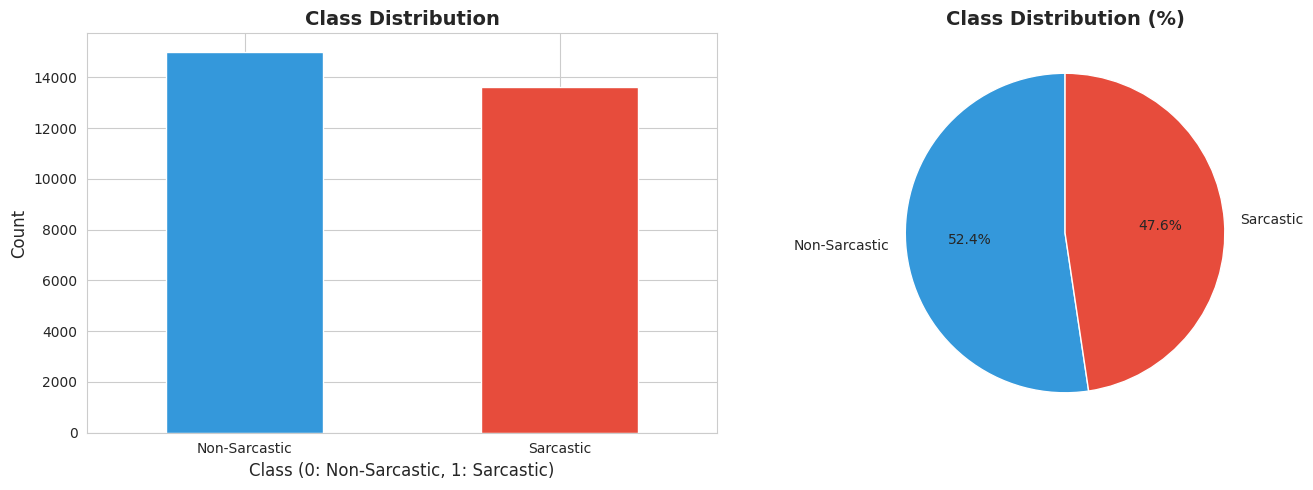

In [15]:
# Class Distribution ---
print("\n--- Class Distribution ---")
class_counts = df['label'].value_counts()
print(f"\nClass distribution:")
print(class_counts)
print(f"\nPercentage distribution:")
print(df['label'].value_counts(normalize=True) * 100)

# Plot class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
class_counts.plot(kind='bar', ax=axes[0], color=['#3498db', '#e74c3c'])
axes[0].set_title('Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class (0: Non-Sarcastic, 1: Sarcastic)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_xticklabels(['Non-Sarcastic', 'Sarcastic'], rotation=0)

# Pie chart
axes[1].pie(class_counts, labels=['Non-Sarcastic', 'Sarcastic'],
           autopct='%1.1f%%', startangle=90, colors=['#3498db', '#e74c3c'])
axes[1].set_title('Class Distribution (%)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


--- Text Length Analysis ---

Text Length Statistics (characters):
         count       mean        std  min   25%   50%   75%    max
label                                                             
0      14985.0  59.558625  17.318876  7.0  48.0  61.0  71.0  228.0
1      13634.0  65.331011  23.551257  8.0  49.0  64.0  80.0  926.0

Word Count Statistics:
         count       mean       std  min  25%   50%   75%    max
label                                                           
0      14985.0   9.815616  2.886045  2.0  8.0  10.0  12.0   38.0
1      13634.0  10.307540  3.849470  2.0  8.0  10.0  13.0  151.0


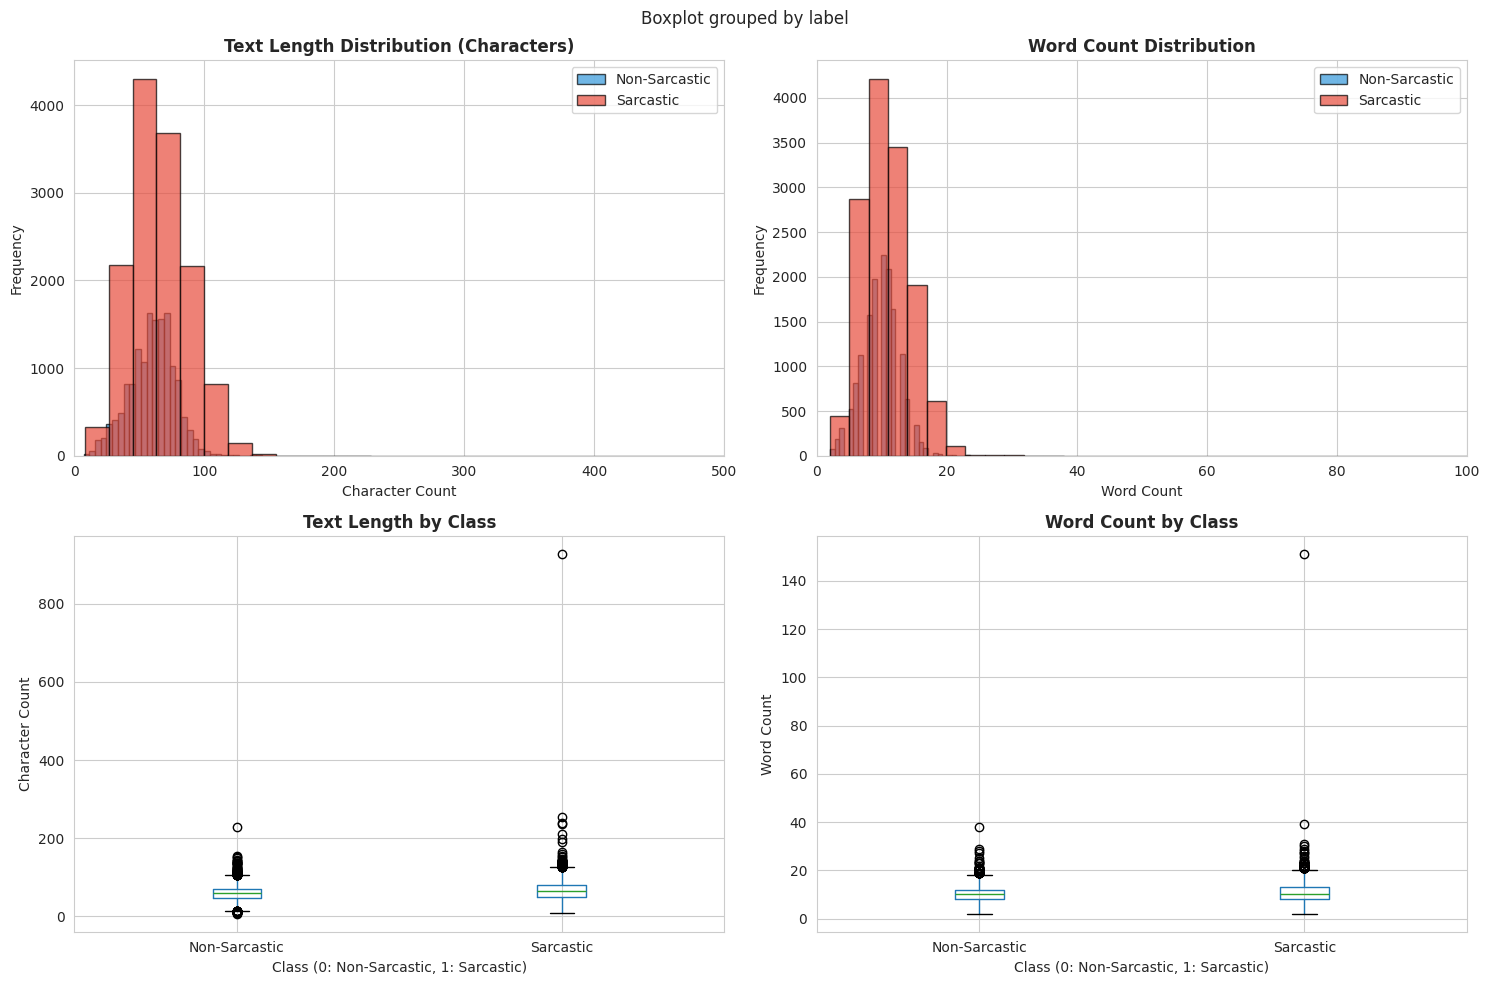

In [17]:
# Text Length Analysis ---
print("\n--- Text Length Analysis ---")

# Calculate text lengths
df['text_length'] = df['text'].str.len()
df['word_count'] = df['text'].str.split().str.len()

print(f"\nText Length Statistics (characters):")
print(df.groupby('label')['text_length'].describe())

print(f"\nWord Count Statistics:")
print(df.groupby('label')['word_count'].describe())

# Plot text length distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Character length distribution
axes[0, 0].hist(df[df['label']==0]['text_length'], bins=50, alpha=0.7,
               label='Non-Sarcastic', color='#3498db', edgecolor='black')
axes[0, 0].hist(df[df['label']==1]['text_length'], bins=50, alpha=0.7,
               label='Sarcastic', color='#e74c3c', edgecolor='black')
axes[0, 0].set_title('Text Length Distribution (Characters)', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Character Count')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].set_xlim(0, 500)

# Word count distribution
axes[0, 1].hist(df[df['label']==0]['word_count'], bins=50, alpha=0.7,
               label='Non-Sarcastic', color='#3498db', edgecolor='black')
axes[0, 1].hist(df[df['label']==1]['word_count'], bins=50, alpha=0.7,
               label='Sarcastic', color='#e74c3c', edgecolor='black')
axes[0, 1].set_title('Word Count Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Word Count')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].set_xlim(0, 100)

# Box plots for comparison
df.boxplot(column='text_length', by='label', ax=axes[1, 0])
axes[1, 0].set_title('Text Length by Class', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Class (0: Non-Sarcastic, 1: Sarcastic)')
axes[1, 0].set_ylabel('Character Count')
plt.sca(axes[1, 0])
plt.xticks([1, 2], ['Non-Sarcastic', 'Sarcastic'])

df.boxplot(column='word_count', by='label', ax=axes[1, 1])
axes[1, 1].set_title('Word Count by Class', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Class (0: Non-Sarcastic, 1: Sarcastic)')
axes[1, 1].set_ylabel('Word Count')
plt.sca(axes[1, 1])
plt.xticks([1, 2], ['Non-Sarcastic', 'Sarcastic'])

plt.tight_layout()
plt.show()

** Word Frequency Analysis- Preprocess Text**

In [21]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Keep only letters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text


Top 20 words in SARCASTIC texts:
  man: 1155
  new: 1000
  report: 516
  area: 487
  woman: 356
  trump: 343
  one: 296
  time: 279
  day: 272
  still: 248
  study: 241
  like: 238
  nation: 232
  get: 229
  back: 217
  finds: 210
  house: 209
  first: 206
  family: 199
  americans: 198

Top 20 words in NON-SARCASTIC texts:
  trump: 1046
  new: 677
  donald: 455
  trumps: 367
  says: 349
  one: 259
  women: 252
  first: 229
  people: 227
  day: 221
  man: 218
  make: 217
  like: 209
  get: 206
  black: 203
  gop: 202
  obama: 190
  world: 189
  white: 185
  life: 184


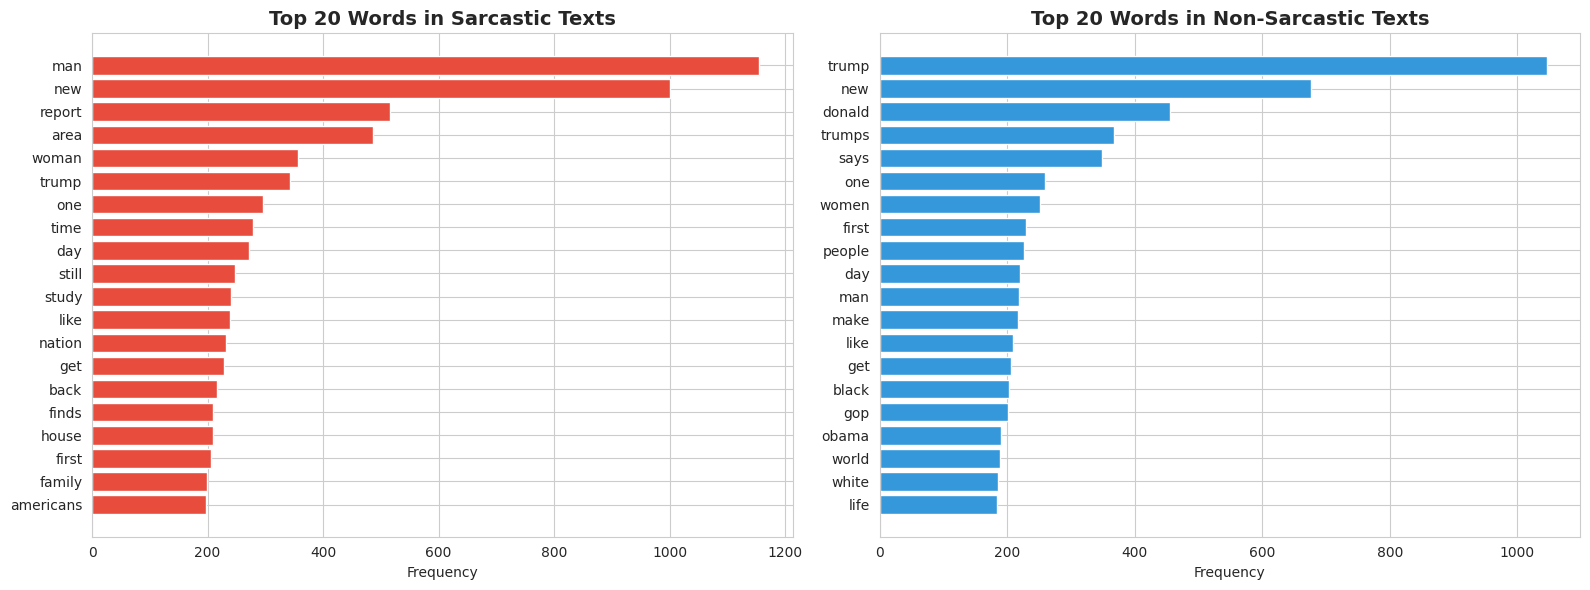

In [22]:
# Preprocess all texts
df['cleaned_text'] = df['text'].apply(preprocess_text)

# Get stop words
stop_words = set(stopwords.words('english'))

def get_top_words(texts, n=20):
    """Extract top n most common words from a list of texts"""
    words = ' '.join(texts).split()
    words = [w for w in words if w not in stop_words and len(w) > 2]
    return Counter(words).most_common(n)

# Get top words for each class
sarcastic_texts = df[df['label']==1]['cleaned_text'].tolist()
non_sarcastic_texts = df[df['label']==0]['cleaned_text'].tolist()

top_sarcastic = get_top_words(sarcastic_texts, 20)
top_non_sarcastic = get_top_words(non_sarcastic_texts, 20)

print(f"\nTop 20 words in SARCASTIC texts:")
for word, count in top_sarcastic:
    print(f"  {word}: {count}")

print(f"\nTop 20 words in NON-SARCASTIC texts:")
for word, count in top_non_sarcastic:
    print(f"  {word}: {count}")

# Plot top words
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

words_s, counts_s = zip(*top_sarcastic)
axes[0].barh(words_s, counts_s, color='#e74c3c')
axes[0].set_title('Top 20 Words in Sarcastic Texts', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Frequency')
axes[0].invert_yaxis()

words_ns, counts_ns = zip(*top_non_sarcastic)
axes[1].barh(words_ns, counts_ns, color='#3498db')
axes[1].set_title('Top 20 Words in Non-Sarcastic Texts', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Frequency')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [23]:
#  Sample Examples ---
print("\n--- Sample Examples ---")
print("\nSample SARCASTIC texts:")
for i, text in enumerate(df[df['label']==1]['text'].head(5), 1):
    print(f"{i}. {text}")

print("\nSample NON-SARCASTIC texts:")
for i, text in enumerate(df[df['label']==0]['text'].head(5), 1):
    print(f"{i}. {text}")


--- Sample Examples ---

Sample SARCASTIC texts:
1. thirtysomething scientists unveil doomsday clock of hair loss
2. inclement weather prevents liar from getting to work
3. mother comes pretty close to using word 'streaming' correctly
4. richard branson's global-warming donation nearly as much as cost of failed balloon trips
5. shadow government getting too large to meet in marriott conference room b

Sample NON-SARCASTIC texts:
1. dem rep. totally nails why congress is falling short on gender, racial equality
2. eat your veggies: 9 deliciously different recipes
3. my white inheritance
4. 5 ways to file your taxes with less stress
5. lots of parents know this scenario


# SECTION 4: DATA PREPROCESSING AND TRAIN-TEST SPLIT

For deep learning models, we need to:
1. Split data into train and test sets
2. Further split train into train and validation
3. Ensure balanced representation of classes

In [24]:
# Split into train and test sets (80-20 split)
# stratify ensures balanced class distribution
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['text'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

# Further split train into train and validation (80-20 of train, so 64-16-20 overall)
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts,
    train_labels,
    test_size=0.2,
    random_state=42,
    stratify=train_labels
)

print(f"\n✓ Data split completed:")
print(f"  Training samples: {len(train_texts)}")
print(f"  Validation samples: {len(val_texts)}")
print(f"  Test samples: {len(test_texts)}")

print(f"\n✓ Class distribution in splits:")
print(f"  Train - Sarcastic: {sum(train_labels)}, Non-Sarcastic: {len(train_labels)-sum(train_labels)}")
print(f"  Val - Sarcastic: {sum(val_labels)}, Non-Sarcastic: {len(val_labels)-sum(val_labels)}")
print(f"  Test - Sarcastic: {sum(test_labels)}, Non-Sarcastic: {len(test_labels)-sum(test_labels)}")


✓ Data split completed:
  Training samples: 18316
  Validation samples: 4579
  Test samples: 5724

✓ Class distribution in splits:
  Train - Sarcastic: 8726, Non-Sarcastic: 9590
  Val - Sarcastic: 2181, Non-Sarcastic: 2398
  Test - Sarcastic: 2727, Non-Sarcastic: 2997


# SECTION 5: BASELINE MODELS
We implement two baseline models for comparison:
1. Logistic Regression with TF-IDF features
2. Multinomial Naive Bayes with TF-IDF features

These models use bag-of-words approach and don't capture context like BERT.

In [25]:
# Feature Extraction with TF-IDF ---
# Initialize TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    stop_words='english'
)

# Fit on training data and transform all splits
print("Transforming texts to TF-IDF features...")
X_train_tfidf = tfidf_vectorizer.fit_transform(train_texts)
X_val_tfidf = tfidf_vectorizer.transform(val_texts)
X_test_tfidf = tfidf_vectorizer.transform(test_texts)

print(f"✓ TF-IDF feature shape: {X_train_tfidf.shape}")
print(f"✓ Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

Transforming texts to TF-IDF features...
✓ TF-IDF feature shape: (18316, 5000)
✓ Vocabulary size: 5000


In [26]:
#  Logistic Regression ---

lr_model = LogisticRegression(
    max_iter=1000,
    random_state=42,
    class_weight='balanced'  # Handle class imbalance if any
)

# Train the model
lr_model.fit(X_train_tfidf, train_labels)

# Predict on validation and test sets
lr_val_preds = lr_model.predict(X_val_tfidf)
lr_test_preds = lr_model.predict(X_test_tfidf)

# Calculate metrics
lr_val_acc = accuracy_score(val_labels, lr_val_preds)
lr_test_acc = accuracy_score(test_labels, lr_test_preds)
lr_precision, lr_recall, lr_f1, _ = precision_recall_fscore_support(
    test_labels, lr_test_preds, average='binary'
)

print(f"\n✓ Logistic Regression Results:")
print(f"  Validation Accuracy: {lr_val_acc:.4f}")
print(f"  Test Accuracy: {lr_test_acc:.4f}")
print(f"  Test Precision: {lr_precision:.4f}")
print(f"  Test Recall: {lr_recall:.4f}")
print(f"  Test F1-Score: {lr_f1:.4f}")



✓ Logistic Regression Results:
  Validation Accuracy: 0.7875
  Test Accuracy: 0.7820
  Test Precision: 0.7806
  Test Recall: 0.7543
  Test F1-Score: 0.7673


In [27]:
#  Naive Bayes ---
nb_model = MultinomialNB(alpha=1.0)

# Train the model
nb_model.fit(X_train_tfidf, train_labels)

# Predict on validation and test sets
nb_val_preds = nb_model.predict(X_val_tfidf)
nb_test_preds = nb_model.predict(X_test_tfidf)

# Calculate metrics
nb_val_acc = accuracy_score(val_labels, nb_val_preds)
nb_test_acc = accuracy_score(test_labels, nb_test_preds)
nb_precision, nb_recall, nb_f1, _ = precision_recall_fscore_support(
    test_labels, nb_test_preds, average='binary'
)

print(f"\n✓ Naive Bayes Results:")
print(f"  Validation Accuracy: {nb_val_acc:.4f}")
print(f"  Test Accuracy: {nb_test_acc:.4f}")
print(f"  Test Precision: {nb_precision:.4f}")
print(f"  Test Recall: {nb_recall:.4f}")
print(f"  Test F1-Score: {nb_f1:.4f}")

# Store baseline results for later comparison
baseline_results = {
    'Logistic Regression': {
        'accuracy': lr_test_acc,
        'precision': lr_precision,
        'recall': lr_recall,
        'f1': lr_f1
    },
    'Naive Bayes': {
        'accuracy': nb_test_acc,
        'precision': nb_precision,
        'recall': nb_recall,
        'f1': nb_f1
    }
}


✓ Naive Bayes Results:
  Validation Accuracy: 0.7871
  Test Accuracy: 0.7760
  Test Precision: 0.7804
  Test Recall: 0.7374
  Test F1-Score: 0.7583


# SECTION 6: BERT TOKENIZATION AND DATASET PREPARATION
BERT requires special tokenization:
- Text is split into WordPiece tokens
- Special tokens [CLS] and [SEP] are added
- Tokens are converted to input IDs
- Attention masks indicate real vs padded tokens

In [28]:
# --- Initialize BERT Tokenizer ---
print("\n--- Initializing BERT Tokenizer ---")

MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

print(f" Loaded tokenizer: {MODEL_NAME}")
print(f" Vocabulary size: {tokenizer.vocab_size}")

#  Tokenization Parameters ---
# Analyze token lengths to choose appropriate MAX_LENGTH
sample_texts = train_texts[:1000]
token_lengths = [len(tokenizer.encode(text, add_special_tokens=True)) for text in sample_texts]

print(f"\n Token length statistics (sample):")
print(f"  Mean: {np.mean(token_lengths):.2f}")
print(f"  Median: {np.median(token_lengths):.2f}")
print(f"  95th percentile: {np.percentile(token_lengths, 95):.2f}")
print(f"  Max: {max(token_lengths)}")

# Set MAX_LENGTH to cover 95% of sequences
MAX_LENGTH = min(128, int(np.percentile(token_lengths, 95)) + 10)
print(f"\n Using MAX_LENGTH: {MAX_LENGTH}")


--- Initializing BERT Tokenizer ---


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

 Loaded tokenizer: bert-base-uncased
 Vocabulary size: 30522

 Token length statistics (sample):
  Mean: 14.74
  Median: 15.00
  95th percentile: 22.00
  Max: 30

 Using MAX_LENGTH: 32


In [31]:
# Create PyTorch Dataset Class ---
class SarcasmDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):

        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [32]:
# ---  Create Dataset Instances ---
train_dataset = SarcasmDataset(train_texts, train_labels, tokenizer, MAX_LENGTH)
val_dataset = SarcasmDataset(val_texts, val_labels, tokenizer, MAX_LENGTH)
test_dataset = SarcasmDataset(test_texts, test_labels, tokenizer, MAX_LENGTH)

print(f" Training dataset size: {len(train_dataset)}")
print(f" Validation dataset size: {len(val_dataset)}")
print(f" Test dataset size: {len(test_dataset)}")

#  example of tokenized input
print("\n Example tokenized input:")
sample = train_dataset[0]
print(f"  Input IDs shape: {sample['input_ids'].shape}")
print(f"  Attention mask shape: {sample['attention_mask'].shape}")
print(f"  Label: {sample['labels'].item()}")
print(f"\n  Sample text: {train_texts[0]}")
print(f"  Decoded tokens: {tokenizer.decode(sample['input_ids'])}")

 Training dataset size: 18316
 Validation dataset size: 4579
 Test dataset size: 5724

 Example tokenized input:
  Input IDs shape: torch.Size([32])
  Attention mask shape: torch.Size([32])
  Label: 1

  Sample text: desperate ohio now exploring homeopathic execution methods
  Decoded tokens: [CLS] desperate ohio now exploring homeopathic execution methods [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


In [33]:
# Create DataLoaders ---
BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"\nDataLoaders created:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")


DataLoaders created:
  Batch size: 16
  Training batches: 1145
  Validation batches: 287
  Test batches: 358


# SECTION 7: BERT MODEL SETUP AND TRAINING
We'll fine-tune BERT for binary classification:
1. Load pre-trained BERT model
2. Add classification head
3. Set up optimizer and learning rate scheduler
4. Train with evaluation on validation set

In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n✓ Using device: {device}")

# Load pre-trained BERT model with classification head
# num_labels=2 for binary classification
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
)



✓ Using device: cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
# Move model to device
model = model.to(device)

print(f" Loaded model: {MODEL_NAME}")
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f" Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

 Loaded model: bert-base-uncased
Model parameters: 109,483,778
 Trainable parameters: 109,483,778


**-Training Configuration**

In [36]:
# ---Training Configuration ---
EPOCHS = 3
LEARNING_RATE = 2e-5
WEIGHT_DECAY = 0.01
WARMUP_STEPS = 0

# Calculate total training steps
total_steps = len(train_loader) * EPOCHS
WARMUP_STEPS = total_steps // 10

print(f"\n Training Configuration:")
print(f"  Epochs: {EPOCHS}")
print(f"  Learning Rate: {LEARNING_RATE}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Total Training Steps: {total_steps}")
print(f"  Warmup Steps: {WARMUP_STEPS}")


 Training Configuration:
  Epochs: 3
  Learning Rate: 2e-05
  Batch Size: 16
  Total Training Steps: 3435
  Warmup Steps: 343


In [37]:
# -- Optimizer and Scheduler ---

no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {
        'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
        'weight_decay': WEIGHT_DECAY
    },
    {
        'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
        'weight_decay': 0.0
    }
]

optimizer = AdamW(optimizer_grouped_parameters, lr=LEARNING_RATE)

# Learning rate scheduler with linear warmup and decay
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=WARMUP_STEPS,
    num_training_steps=total_steps
)

print(f" Optimizer and scheduler initialized")

 Optimizer and scheduler initialized


** Training and Evaluation Functions**

In [38]:
#  Training and Evaluation Functions ---

def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0

    # Progress tracking
    from tqdm import tqdm
    progress_bar = tqdm(data_loader, desc='Training')

    for batch in progress_bar:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass
        loss.backward()

        # Clip gradients to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Update weights
        optimizer.step()

        # Update learning rate
        scheduler.step()

        # Update progress bar
        progress_bar.set_postfix({'loss': loss.item()})

    return total_loss / len(data_loader)

def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    total_loss = 0

    # Progress tracking
    from tqdm import tqdm
    progress_bar = tqdm(data_loader, desc='Evaluating')

    # No gradient computation during evaluation
    with torch.no_grad():
        for batch in progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()

            # Get predictions
            preds = torch.argmax(logits, dim=1)

            # Store predictions and labels
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

            # Update progress bar
            progress_bar.set_postfix({'loss': loss.item()})

    avg_loss = total_loss / len(data_loader)
    return predictions, true_labels, avg_loss


Training **Loop**

In [40]:
# ---  Training Loop ---
# Store training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_accuracy': [],
    'val_f1': []
}

best_val_f1 = 0
best_model_state = None

for epoch in range(EPOCHS):
    print(f"\n{'='*60}")
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print(f"{'='*60}")

    # Train for one epoch
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, device)
    print(f"\n Average training loss: {train_loss:.4f}")

    # Evaluate on validation set
    val_preds, val_true, val_loss = evaluate(model, val_loader, device)

    # Calculate metrics
    val_accuracy = accuracy_score(val_true, val_preds)
    val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
        val_true, val_preds, average='binary'
    )

    print(f" Validation loss: {val_loss:.4f}")
    print(f"Validation accuracy: {val_accuracy:.4f}")
    print(f"Validation precision: {val_precision:.4f}")
    print(f"Validation recall: {val_recall:.4f}")
    print(f"Validation F1-score: {val_f1:.4f}")

    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)
    history['val_f1'].append(val_f1)

    # Save best model based on F1-score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = model.state_dict().copy()
        print(f" New best model! (F1: {best_val_f1:.4f})")

print("\n" + "="*60)
print("TRAINING COMPLETED")
print("="*60)
print(f"Best validation F1-score: {best_val_f1:.4f}")

# Load best model
model.load_state_dict(best_model_state)
print("Loaded best model")


Epoch 1/3


Training: 100%|██████████| 1145/1145 [02:39<00:00,  7.18it/s, loss=0.391]



 Average training loss: 0.3369


Evaluating: 100%|██████████| 287/287 [00:13<00:00, 21.33it/s, loss=0.0174]


 Validation loss: 0.2042
Validation accuracy: 0.9238
Validation precision: 0.9221
Validation recall: 0.9175
Validation F1-score: 0.9198
 New best model! (F1: 0.9198)

Epoch 2/3


Training: 100%|██████████| 1145/1145 [02:44<00:00,  6.97it/s, loss=0.104]



 Average training loss: 0.1477


Evaluating: 100%|██████████| 287/287 [00:11<00:00, 24.42it/s, loss=0.00189]


 Validation loss: 0.2406
Validation accuracy: 0.9340
Validation precision: 0.9450
Validation recall: 0.9147
Validation F1-score: 0.9296
 New best model! (F1: 0.9296)

Epoch 3/3


Training: 100%|██████████| 1145/1145 [02:41<00:00,  7.08it/s, loss=0.000652]



 Average training loss: 0.0624


Evaluating: 100%|██████████| 287/287 [00:13<00:00, 21.74it/s, loss=0.000497]


 Validation loss: 0.3152
Validation accuracy: 0.9360
Validation precision: 0.9407
Validation recall: 0.9239
Validation F1-score: 0.9322
 New best model! (F1: 0.9322)

TRAINING COMPLETED
Best validation F1-score: 0.9322
Loaded best model



--- Training History ---


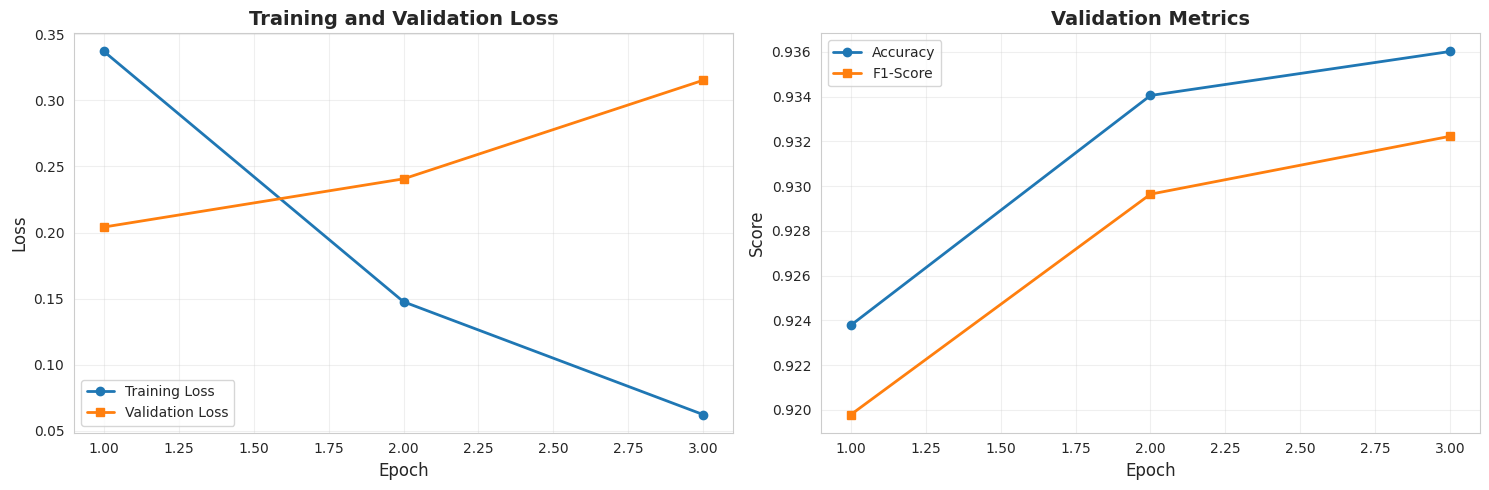

In [42]:
#  Plot Training History ---
print("\n--- Training History ---")

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(range(1, EPOCHS+1), history['train_loss'], 'o-', label='Training Loss', linewidth=2)
axes[0].plot(range(1, EPOCHS+1), history['val_loss'], 's-', label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Metrics plot
axes[1].plot(range(1, EPOCHS+1), history['val_accuracy'], 'o-', label='Accuracy', linewidth=2)
axes[1].plot(range(1, EPOCHS+1), history['val_f1'], 's-', label='F1-Score', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Validation Metrics', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# SECTION 8: MODEL EVALUATION ON TEST SET

Evaluating: 100%|██████████| 358/358 [00:14<00:00, 23.89it/s, loss=0.698]



 BERT Test Results:
  Test Loss: 0.3703
  Test Accuracy: 0.9263
  Test Precision: 0.9361
  Test Recall: 0.9072
  Test F1-Score: 0.9214

 Detailed Classification Report:
               precision    recall  f1-score   support

Non-Sarcastic       0.92      0.94      0.93      2997
    Sarcastic       0.94      0.91      0.92      2727

     accuracy                           0.93      5724
    macro avg       0.93      0.93      0.93      5724
 weighted avg       0.93      0.93      0.93      5724


 Confusion Matrix:
[[2828  169]
 [ 253 2474]]


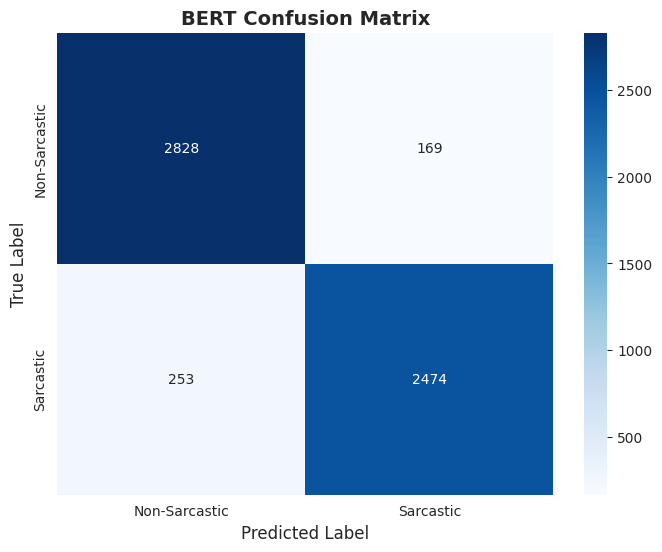

In [41]:
# Evaluate BERT on test set
test_preds, test_true, test_loss = evaluate(model, test_loader, device)

# Calculate comprehensive metrics
test_accuracy = accuracy_score(test_true, test_preds)
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
    test_true, test_preds, average='binary'
)

print(f"\n BERT Test Results:")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f}")
print(f"  Test Precision: {test_precision:.4f}")
print(f"  Test Recall: {test_recall:.4f}")
print(f"  Test F1-Score: {test_f1:.4f}")

# Detailed classification report
print(f"\n Detailed Classification Report:")
print(classification_report(test_true, test_preds,
                          target_names=['Non-Sarcastic', 'Sarcastic']))

# Confusion Matrix
cm = confusion_matrix(test_true, test_preds)
print(f"\n Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['Non-Sarcastic', 'Sarcastic'],
           yticklabels=['Non-Sarcastic', 'Sarcastic'])
plt.title('BERT Confusion Matrix', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()


# SECTION 9: MODEL COMPARISON
Compare all models:
1. Logistic Regression (baseline)
2. Naive Bayes (baseline)
3. BERT (fine-tuned)

In [45]:
# Compile all results
all_results = baseline_results.copy()
all_results['BERT'] = {
    'accuracy': test_accuracy,
    'precision': test_precision,
    'recall': test_recall,
    'f1': test_f1
}

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_results).T
print("\n Model Comparison:")
print(comparison_df.round(4))


 Model Comparison:
                     accuracy  precision  recall      f1
Logistic Regression    0.7820     0.7806  0.7543  0.7673
Naive Bayes            0.7760     0.7804  0.7374  0.7583
BERT                   0.9263     0.9361  0.9072  0.9214


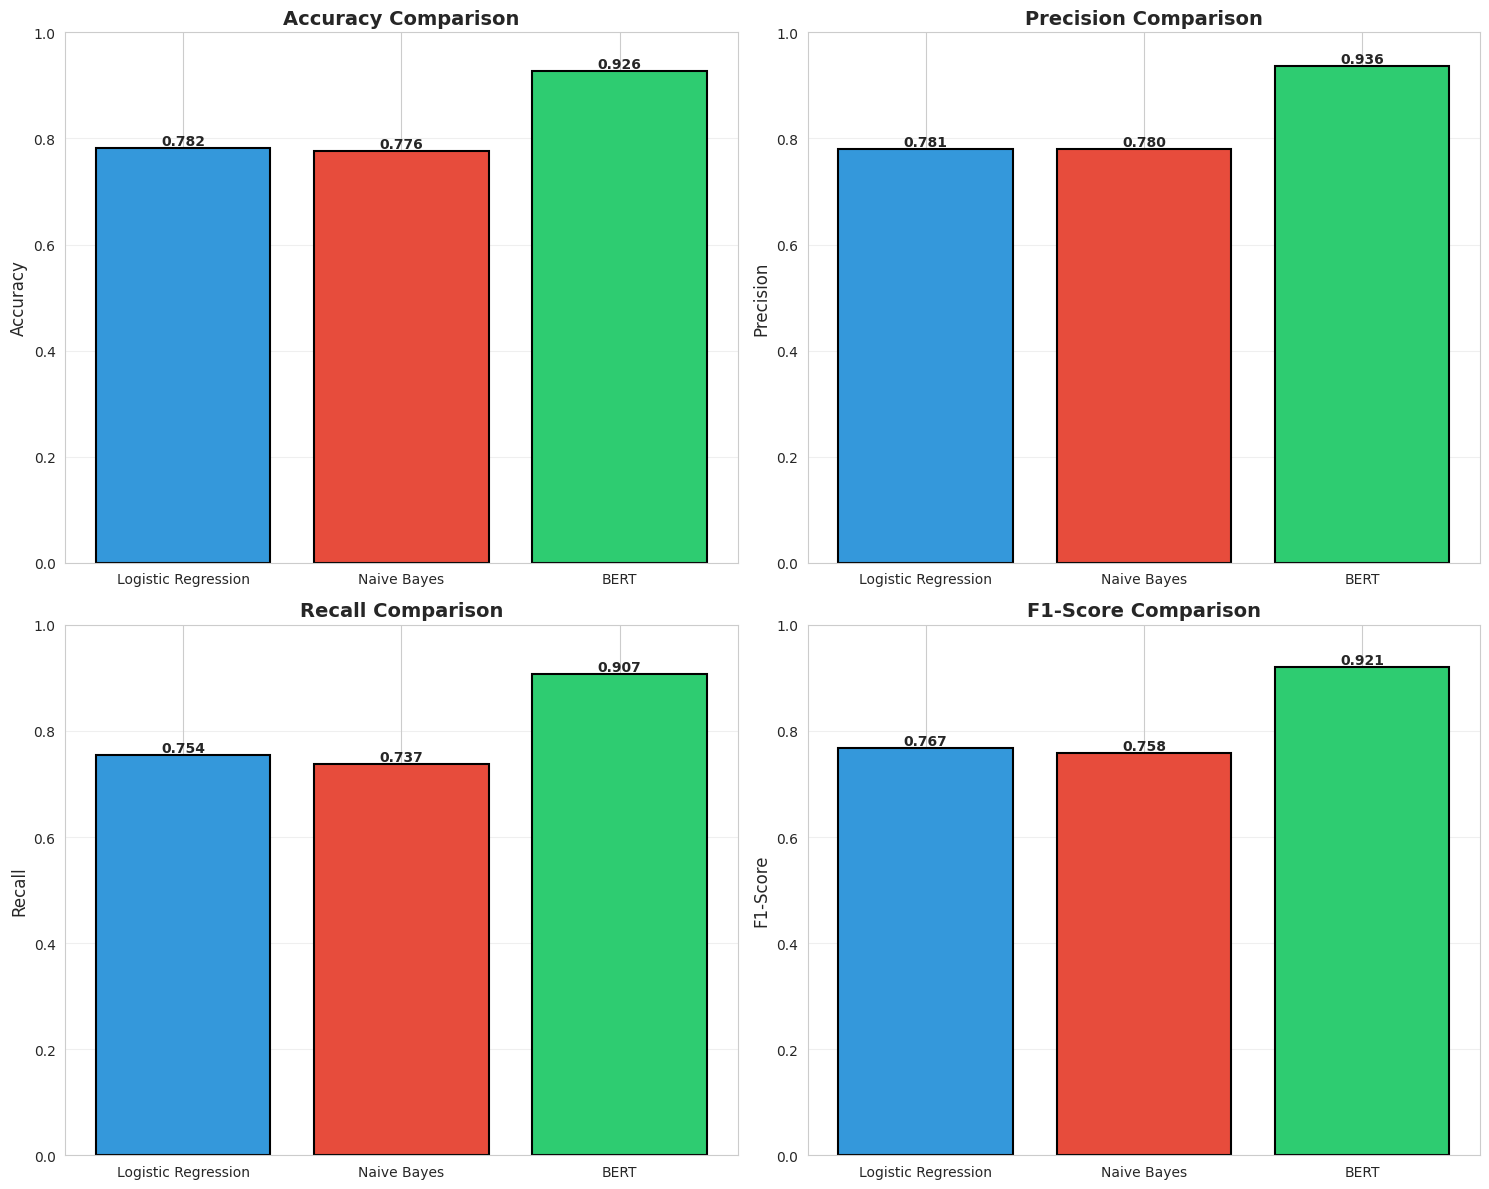

In [46]:
# Bar plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
metrics = ['accuracy', 'precision', 'recall', 'f1']
titles = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx // 2, idx % 2]
    values = comparison_df[metric].values
    models = comparison_df.index.tolist()

    bars = ax.bar(models, values, color=colors, edgecolor='black', linewidth=1.5)
    ax.set_ylabel(title, fontsize=12)
    ax.set_title(f'{title} Comparison', fontsize=14, fontweight='bold')
    ax.set_ylim(0, 1.0)
    ax.grid(True, axis='y', alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.3f}',
               ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

In [47]:
# ---  Statistical Comparison ---
print("\n Performance Improvements over Best Baseline:")

best_baseline = 'Logistic Regression' if baseline_results['Logistic Regression']['f1'] > baseline_results['Naive Bayes']['f1'] else 'Naive Bayes'
print(f"\nBest Baseline Model: {best_baseline}")

for metric in metrics:
    baseline_score = comparison_df.loc[best_baseline, metric]
    bert_score = comparison_df.loc['BERT', metric]
    improvement = ((bert_score - baseline_score) / baseline_score) * 100

    print(f"\n{metric.capitalize()}:")
    print(f"  {best_baseline}: {baseline_score:.4f}")
    print(f"  BERT: {bert_score:.4f}")
    print(f"  Improvement: {improvement:+.2f}%")


 Performance Improvements over Best Baseline:

Best Baseline Model: Logistic Regression

Accuracy:
  Logistic Regression: 0.7820
  BERT: 0.9263
  Improvement: +18.45%

Precision:
  Logistic Regression: 0.7806
  BERT: 0.9361
  Improvement: +19.91%

Recall:
  Logistic Regression: 0.7543
  BERT: 0.9072
  Improvement: +20.27%

F1:
  Logistic Regression: 0.7673
  BERT: 0.9214
  Improvement: +20.09%


# SECTION 10: ERROR ANALYSIS
Analyze where BERT makes mistakes to understand limitations:
1. False Positives: Non-sarcastic classified as sarcastic
2. False Negatives: Sarcastic classified as non-sarcastic


✓ Total test samples: 5724
✓ Incorrect predictions: 422 (7.37%)

 False Positives: 169 (Non-sarcastic → Sarcastic)
 False Negatives: 253 (Sarcastic → Non-sarcastic)
SAMPLE FALSE POSITIVES (Non-sarcastic predicted as Sarcastic)

1. noose found in african-american history museum exhibit in d.c.

2. jennifer lopez rear-ended by drunk driver

3. trump reads fake version of own speech

4. feds find criminal wrongdoing in g.m.'s failure to disclose defect

5. pope criticizes conservatives at key church gathering
SAMPLE FALSE NEGATIVES (Sarcastic predicted as Non-sarcastic)

1. tom gilbert, actor who portrays tv's regis philbin, to leave 'regis & kelly' show

2. expansive obama state of the union speech to touch on patent law, entomology, the films of robert altman

3. u.s. asks africa not to cash aid checks until after tax day

4. kfc blames popeyes for releasing serial rapist from prison in new attack ad campaign

5. per tradition, ex-presidents watch obamas christen white house bed

 Text

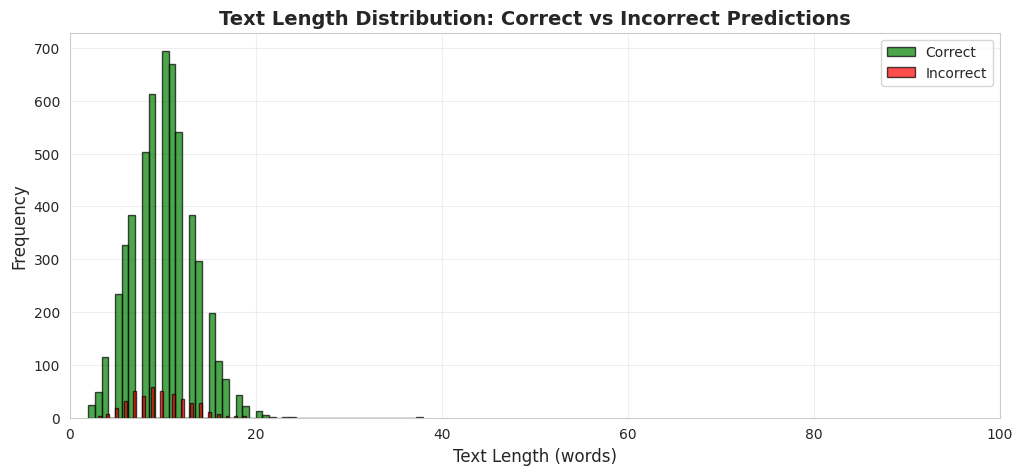

In [48]:
# Get indices of incorrect predictions
test_preds_array = np.array(test_preds)
test_true_array = np.array(test_true)
incorrect_idx = np.where(test_preds_array != test_true_array)[0]

print(f"\n✓ Total test samples: {len(test_true)}")
print(f"✓ Incorrect predictions: {len(incorrect_idx)} ({len(incorrect_idx)/len(test_true)*100:.2f}%)")

# False Positives and False Negatives
false_positives = [i for i in incorrect_idx if test_true_array[i] == 0 and test_preds_array[i] == 1]
false_negatives = [i for i in incorrect_idx if test_true_array[i] == 1 and test_preds_array[i] == 0]

print(f"\n False Positives: {len(false_positives)} (Non-sarcastic → Sarcastic)")
print(f" False Negatives: {len(false_negatives)} (Sarcastic → Non-sarcastic)")

# -- Sample False Positives ---
print("SAMPLE FALSE POSITIVES (Non-sarcastic predicted as Sarcastic)")
print("="*60)

for i, idx in enumerate(false_positives[:5], 1):
    print(f"\n{i}. {test_texts[idx]}")

# -- Sample False Negatives ---
print("SAMPLE FALSE NEGATIVES (Sarcastic predicted as Non-sarcastic)")
print("="*60)

for i, idx in enumerate(false_negatives[:5], 1):
    print(f"\n{i}. {test_texts[idx]}")

# ---  Length Analysis of Errors ---
error_lengths = [len(test_texts[i].split()) for i in incorrect_idx]
correct_lengths = [len(test_texts[i].split()) for i in range(len(test_texts)) if i not in incorrect_idx]

print(f"\n Text Length Analysis:")
print(f"  Average length of incorrect predictions: {np.mean(error_lengths):.2f} words")
print(f"  Average length of correct predictions: {np.mean(correct_lengths):.2f} words")

plt.figure(figsize=(12, 5))
plt.hist(correct_lengths, bins=50, alpha=0.7, label='Correct', color='green', edgecolor='black')
plt.hist(error_lengths, bins=50, alpha=0.7, label='Incorrect', color='red', edgecolor='black')
plt.xlabel('Text Length (words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Text Length Distribution: Correct vs Incorrect Predictions',
         fontsize=14, fontweight='bold')
plt.legend()
plt.xlim(0, 100)
plt.grid(True, alpha=0.3)
plt.show()


# SECTION 12: SUMMARY AND CONCLUSIONS

In [49]:
print("\n" + "="*80)
print("SUMMARY AND KEY FINDINGS")
print("="*80)

print(f"""
📌 KEY RESULTS:

1. Dataset:
   - Total samples: {len(df)}
   - Training samples: {len(train_texts)}
   - Test samples: {len(test_texts)}
   - Class distribution: Relatively balanced

2. Model Performance (Test Set):

   Logistic Regression:
   - Accuracy: {baseline_results['Logistic Regression']['accuracy']:.4f}
   - F1-Score: {baseline_results['Logistic Regression']['f1']:.4f}

   Naive Bayes:
   - Accuracy: {baseline_results['Naive Bayes']['accuracy']:.4f}
   - F1-Score: {baseline_results['Naive Bayes']['f1']:.4f}

   BERT (Fine-tuned):
   - Accuracy: {test_accuracy:.4f}
   - F1-Score: {test_f1:.4f}

""")


SUMMARY AND KEY FINDINGS

📌 KEY RESULTS:

1. Dataset:
   - Total samples: 28619
   - Training samples: 18316
   - Test samples: 5724
   - Class distribution: Relatively balanced

2. Model Performance (Test Set):
   
   Logistic Regression:
   - Accuracy: 0.7820
   - F1-Score: 0.7673
   
   Naive Bayes:
   - Accuracy: 0.7760
   - F1-Score: 0.7583
   
   BERT (Fine-tuned):
   - Accuracy: 0.9263
   - F1-Score: 0.9214
      

